In [22]:
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data
import matplotlib.pyplot as plt
from matplotlib import style
from Trainer import trainer
from DataLoader import ImgDataset
from Model import ResNet
import numpy as np
style.use('ggplot')

In [24]:
# Set device where our training will take place
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [25]:
im_size = 224
batch_size = 50
num_classes = 2
im_channels = 3

In [26]:
def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight

In [27]:
augs = transforms.Compose([
    transforms.Resize(im_size),
    transforms.CenterCrop(im_size),
    transforms.ToTensor()
])

test_augs = transforms.Compose([
    transforms.Resize(im_size),
    transforms.CenterCrop(im_size),
    transforms.ToTensor()
])

path = 'chest_xray'

data = ImgDataset(path, bs=batch_size, aug=augs, test_aug=test_augs)

In [ ]:
# We will oversample the minority class to try to improve predictions

weights = make_weights_for_balanced_classes(data.train_dataset.imgs, len(data.train_dataset.classes))
weights = torch.DoubleTensor(weights)

sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

data.apply_sampler(sampler)

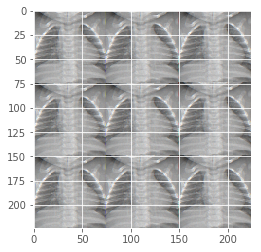

In [28]:
plt.imshow(data.train_dataset[25][0].numpy().reshape(im_size, im_size, 3))

In [29]:
# Import model
model = torchvision.models.resnet50(pretrained='imagenet')

# Change last layer for our classification task
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(num_ftrs, num_classes),
                         nn.LogSoftmax(1))

# Define our Loss function and our Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# load the model into our trainer
learn = trainer(model, criterion, optimizer)

Epoch [1/1], Step [100/105], Loss: 0.6632


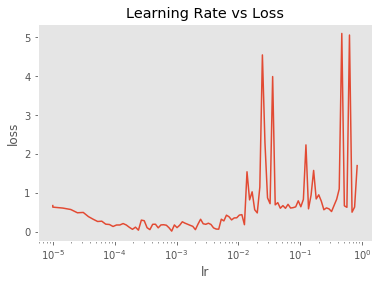

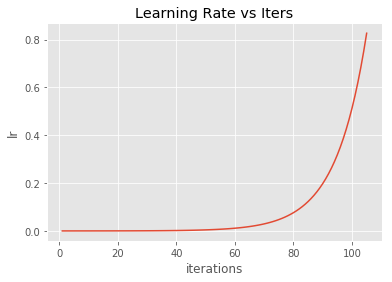

In [30]:
learn.lr_find(data.train)

In [31]:
lr = 1e-4

In [32]:
# Import model
model = torchvision.models.resnet50(pretrained='imagenet')

# Change last layer for our classification task
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(num_ftrs, num_classes),
                         nn.LogSoftmax(1))

# Define our Loss function and our Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# load the model into our trainer
learn = trainer(model, criterion, optimizer)

#################### EPOCH 1 ####################
Epoch [1/15], Step [20/105], Loss: 0.0994
Epoch [1/15], Step [40/105], Loss: 0.0863
Epoch [1/15], Step [60/105], Loss: 0.0750
Epoch [1/15], Step [80/105], Loss: 0.0656
Epoch [1/15], Step [100/105], Loss: 0.0112
Validation Accuracy: 93.75 %
Validation Loss: 0.21113599836826324
#################### EPOCH 2 ####################
Epoch [2/15], Step [20/105], Loss: 0.1954
Epoch [2/15], Step [40/105], Loss: 0.0685
Epoch [2/15], Step [60/105], Loss: 0.0349
Epoch [2/15], Step [80/105], Loss: 0.0969
Epoch [2/15], Step [100/105], Loss: 0.0468
Validation Accuracy: 100.0 %
Validation Loss: 0.055654458701610565
#################### EPOCH 3 ####################
Epoch [3/15], Step [20/105], Loss: 0.0640
Epoch [3/15], Step [40/105], Loss: 0.0030
Epoch [3/15], Step [60/105], Loss: 0.0195
Epoch [3/15], Step [80/105], Loss: 0.0316
Epoch [3/15], Step [100/105], Loss: 0.0019
Validation Accuracy: 100.0 %
Validation Loss: 0.04941720888018608
##################

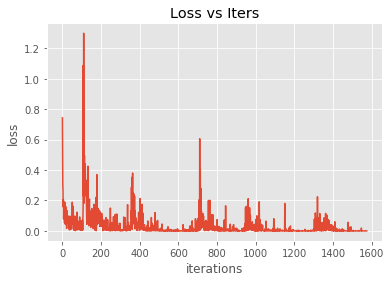

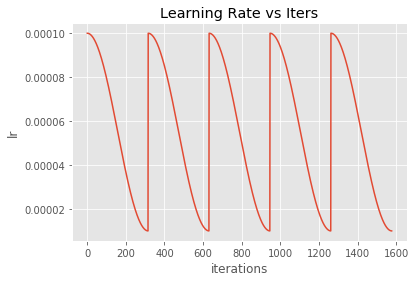

In [33]:
learn.SGDR(data.train, cycles=5, cycle_len=3, cycle_mult=1, valid=data.val, snapshot=True)

#################### EPOCH 1 ####################
#################### EPOCH 2 ####################
#################### EPOCH 3 ####################
#################### EPOCH 4 ####################
#################### EPOCH 5 ####################
#################### EPOCH 6 ####################
#################### EPOCH 7 ####################


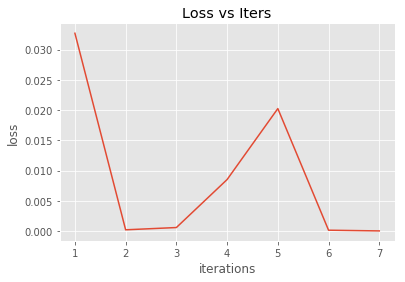

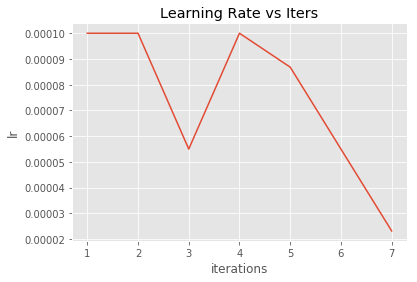

In [39]:
# Quickly train using the validation data before testing
learn.SGDR(data.val, cycles=3, cycle_len=1, cycle_mult=2, snapshot=True)

In [40]:
learn.test(data.test)

Test Accuracy: 90.86538461538461 %
Test Loss: 9.333752317354083


In [41]:
learn.test(data.test, snapshot=2)

Test Accuracy: 90.7051282051282 %
Test Loss: 8.163954916060902
